### gpu 메모리 부족 현상이 발생해서 이에 대한 새로운 접근
mini_batch size: 24->8

In [1]:
import tensorflow as tf
from tensorflow.keras import mixed_precision

# mixed precision 설정
policy = mixed_precision.Policy('mixed_float16')
mixed_precision.set_global_policy(policy)

# GPU 설정
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

2024-06-26 12:51:19.922961: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-26 12:51:20.048636: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPUs will likely run quickly with dtype policy mixed_float16 as they all have compute capability of at least 7.0


In [2]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  4


# 데이터 불러오기 및 클래스 지정과 분할  
The numbers of samples in each class for the test set are distributed as 106 (normal), 24 (AOM), 13 (CSOM), 28 (Earwax), and 20 (Other)

In [3]:
import os

# 데이터셋의 루트 디렉토리
dataset_directory = '/home/jeonk636/ear_classification/eardrumDs'

# 클래스 이름 및 라벨을 매핑하기 위한 딕셔너리 생성
# normal:0, Aom:1, Chornic:2, Earwax:3, Others:4
label_map = {
    'Aom': 1,
    'Chornic': 2,
    'Earwax': 3,
    'Normal': 0,
}

# 이미지 파일 경로 및 라벨을 저장할 리스트
image_paths = []
image_labels = []

exclude_folders = {'OtitExterna', 'tympanoskleros', 'Earventulation', 'Foreign', 'PseduoMembran'}

# 각 폴더에 대해 이미지 파일 경로 및 해당 라벨을 리스트에 추가
for label_folder in os.listdir(dataset_directory):
    if label_folder in exclude_folders:  # 이 폴더는 건너뛴다.
        continue
    folder_path = os.path.join(dataset_directory, label_folder)
    
    for image_filename in os.listdir(folder_path):
        # 폴더 내 파일이 실제 파일인지 확인하고 '.ipynb_checkpoints' 폴더를 건너뛴다.
        full_path = os.path.join(folder_path, image_filename)
        if os.path.isfile(full_path) and '.ipynb_checkpoints' not in full_path:
            image_paths.append(full_path)
            image_labels.append(label_map[label_folder])


In [4]:
label_0_count = image_labels.count(0)
label_1_count = image_labels.count(1)
label_2_count = image_labels.count(2)
label_3_count = image_labels.count(3)

print('Normal:', label_0_count)
print('Aom:', label_1_count)
print('Chornic:', label_2_count)
print('Earwax:', label_3_count)

Normal: 534
Aom: 119
Chornic: 63
Earwax: 140


In [5]:
import numpy as np
from sklearn.model_selection import train_test_split
import pandas as pd

# 이미지 경로와 라벨을 Numpy 배열로 변환
image_paths = np.array(image_paths)
image_labels = np.array(image_labels)

# 데이터프레임으로 변환
data = pd.DataFrame({'image_path': image_paths, 'label': image_labels})

# 클래스별로 지정된 수의 샘플을 추출하여 테스트 세트로 사용(4:20 #other)
test_counts = {
    0: 106,  # Normal
    1: 24,   # AOM
    2: 13,   # CSOM
    3: 28   # Earwax
}

test_data_list = []

for label, count in test_counts.items():
    class_data = data[data['label'] == label]
    if len(class_data) < count:
        raise ValueError(f"Not enough samples for class {label}. Needed {count}, but only {len(class_data)} available.")
    test_data_list.append(class_data.sample(n=count, random_state=42))

test_data = pd.concat(test_data_list)

# 나머지 데이터를 훈련 세트로 사용
train_data = data.drop(test_data.index)

# 훈련 세트와 테스트 세트로 나누기
x_train = train_data['image_path'].values
y_train = train_data['label'].values
x_test = test_data['image_path'].values
y_test = test_data['label'].values

In [6]:
# 결과 출력
print("Training set size:", len(x_train))
print("Test set size:", len(x_test))
print("Test set class distribution:\n", test_data['label'].value_counts())

Training set size: 685
Test set size: 171
Test set class distribution:
 label
0    106
3     28
1     24
2     13
Name: count, dtype: int64


# keras을 사용한 데이터 증강  
224 by 224  
Normal 클래스가 가장 많은 샘플 수를 가지고 있으므로, 이를 기준으로 AOM, CSOM, Earwax 클래스을 각각 3배, 7배, 3배 증강  
증강을 하면 train set에 있는 total sample 수는 normal 428, Aom 380, Csom 400, Earwax 448 으로 각 클래스가 비슷해짐

In [7]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# 레이블을 문자열로 변환
train_data['label'] = train_data['label'].astype(str)
test_data['label'] = test_data['label'].astype(str)

# 데이터 증강 파라미터 정의
data_gen_args = dict(
    rescale=1./255,
    horizontal_flip=True,
    vertical_flip=True,
    brightness_range=[0.7, 1.3],  # ±30% 밝기 조절
    width_shift_range=0.2,  # 좌우 이동 범위 20%
    height_shift_range=0.2,  # 상하 이동 범위 20%
    zoom_range=0.2,  # ±20% 확대/축소
    rotation_range=20  # ±20도 회전
)

# 데이터 증강 제네레이터 생성
datagen = ImageDataGenerator(**data_gen_args)

# 증강된 샘플 수를 지정(4:4 #Other)
augment_counts = {
    1: 3,  # AOM
    2: 7,  # CSOM
    3: 3  # Earwax
}

# 증강된 데이터를 저장할 리스트
augmented_data = []

for label, count in augment_counts.items():
    class_data = train_data[train_data['label'] == str(label)]
    for i in range(count):
        for index, row in class_data.iterrows():
            img = tf.keras.preprocessing.image.load_img(row['image_path'], target_size=(224, 224))
            img_array = tf.keras.preprocessing.image.img_to_array(img)
            img_array = np.expand_dims(img_array, axis=0)
            augmented_iter = datagen.flow(img_array, batch_size=1)
            augmented_img = next(augmented_iter)[0].astype(np.uint8)
            augmented_data.append({'image_path': row['image_path'], 'label': row['label']})
            
# 원본 데이터와 증강 데이터를 결합
augmented_df = pd.DataFrame(augmented_data)
train_data = pd.concat([train_data, augmented_df])

In [8]:
# 데이터 확인
print(train_data['label'].value_counts())
print(augmented_df['label'].value_counts())

label
3    448
0    428
2    400
1    380
Name: count, dtype: int64
label
2    350
3    336
1    285
Name: count, dtype: int64


In [9]:
import matplotlib.pyplot as plt

def plot_training_history(history, epochs_range=None):
    
    if epochs_range is None:
        epochs_range = range(len(history.history['accuracy']))

    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    plt.figure(figsize=(8, 8))
    
    # Training and Validation Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    # Training and Validation Loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')

    plt.show()

In [10]:
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

def evaluate_and_visualize_model(model, val_generator):
    # 모델 예측
    y_pred = model.predict(val_generator)
    y_pred_classes = np.argmax(y_pred, axis=1)

    # 실제 레이블
    y_true = val_generator.classes

    # Classification Report 출력
    print(classification_report(y_true, y_pred_classes, target_names=val_generator.class_indices.keys()))

    # Confusion Matrix 시각화
    cm = confusion_matrix(y_true, y_pred_classes)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=val_generator.class_indices.keys(), yticklabels=val_generator.class_indices.keys())
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()

### 논문

In [11]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, UpSampling2D, Concatenate, GlobalAveragePooling2D, Dense, Dropout, BatchNormalization, Activation, Input, LeakyReLU
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

# logical_gpus = tf.config.experimental.list_logical_devices ('GPU')
# strategy = tf.distribute.MirroredStrategy(logical_gpus)

strategy = tf.distribute.MirroredStrategy()

with strategy.scope():
    # 데이터 증강 설정
    data_gen_args = dict(
        rescale=1./255,
        horizontal_flip=True,
        vertical_flip=True,
        brightness_range=[0.7, 1.3],
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        zoom_range=0.2
    )

    # 데이터 증강 생성기
    train_datagen = ImageDataGenerator(**data_gen_args)
    test_datagen = ImageDataGenerator(rescale=1./255)

    # 데이터 증강 적용 (train_data는 데이터프레임 형태라고 가정)
    train_generator = train_datagen.flow_from_dataframe(
        dataframe=train_data,
        x_col='image_path',
        y_col='label',
        target_size=(224, 224),
        batch_size=16,  # 배치 크기를 줄임
        class_mode='categorical'
    )

    val_generator = test_datagen.flow_from_dataframe(
        dataframe=test_data,
        x_col='image_path',
        y_col='label',
        target_size=(224, 224),
        batch_size=16,  # 배치 크기를 줄임
        class_mode='categorical'
    )

    # Convolutional Block 정의
    def conv_block(x, filters):
        x = Conv2D(filters, (3, 3), padding='same')(x)
        x = BatchNormalization()(x)
        x = Activation('relu')(x)
        return x

    # Residual Block 정의
    def residual_block(x, filters):
        shortcut = x
        x = Conv2D(filters, (3, 3), padding='same', strides=(1, 1))(x)
        x = BatchNormalization()(x)
        x = LeakyReLU()(x)
        x = Conv2D(filters, (3, 3), padding='same', strides=(1, 1))(x)
        x = BatchNormalization()(x)
        x = tf.keras.layers.add([x, shortcut])
        x = LeakyReLU()(x)
        return x

    # Channel Attention Module 정의
    def channel_attention(x):
        avg_pool = GlobalAveragePooling2D()(x)
        max_pool = GlobalAveragePooling2D()(x)
        dense_avg = Dense(x.shape[-1], activation='relu', kernel_initializer='he_normal', use_bias=True, bias_initializer='zeros')(avg_pool)
        dense_max = Dense(x.shape[-1], activation='relu', kernel_initializer='he_normal', use_bias=True, bias_initializer='zeros')(max_pool)
        combined = tf.keras.layers.add([dense_avg, dense_max])
        channel_attention = Activation('sigmoid')(combined)
        return tf.keras.layers.multiply([x, channel_attention])

    # Spatial Attention Module 정의 -> 이게 성능이 더 좋음(논문대로 axis=3으로 하면 성능이 떨어짐)
    def spatial_attention(x):
        avg_pool = tf.reduce_mean(x, axis=-1, keepdims=True) #axis=3
        max_pool = tf.reduce_max(x, axis=-1, keepdims=True) #axis=3
        combined = Concatenate(axis=-1)([avg_pool, max_pool]) #axis=3
        spatial_attention = Conv2D(1, (7, 7), padding='same', activation='sigmoid', kernel_initializer='he_normal', use_bias=False)(combined)
        return tf.keras.layers.multiply([x, spatial_attention])

    # CBAM Block 정의
    def cbam_block(x):
        x = channel_attention(x)
        x = spatial_attention(x)
        return x
    
    # Stage 1 정의
    def stage1(input_tensor):
        x = conv_block(input_tensor, 32)
        x = conv_block(x, 32)
        x = MaxPooling2D((2, 2))(x)
        x = UpSampling2D((2, 2), interpolation='bilinear')(x)  
        return x

    # Stage 2 정의
    def stage2(input_tensor):
        x = conv_block(input_tensor, 64)
        x = cbam_block(x)
        x = residual_block(x, 64)
        x = MaxPooling2D((2, 2))(x)
        x = UpSampling2D((2, 2), interpolation='bilinear')(x)  
        return x

    # Stage 3 정의
    def stage3(input_tensor):
        x = conv_block(input_tensor, 128)
        x = cbam_block(x)
        x = residual_block(x, 128)
        x = MaxPooling2D((2, 2))(x)
        x = UpSampling2D((2, 2), interpolation='bilinear')(x)  
        return x

    # 모델 구성
    input_tensor = Input(shape=(224, 224, 3))

    stage1_output = stage1(input_tensor)
    stage2_output = stage2(stage1_output)
    stage3_output = stage3(stage2_output)
    
    # Concatenate 전에 모든 텐서의 크기를 동일하게 맞추기
    # stage1_output = UpSampling2D(size=(4, 4), interpolation='bilinear')(stage1_output)  # (224, 224, 32) -> (1792, 1792, 32)
    # stage2_output = UpSampling2D(size=(2, 2), interpolation='bilinear')(stage2_output)  # (448, 448, 64) -> (1792, 1792, 64)

    # 필요한 경우 채널 수를 맞추기 위해 Conv2D 사용
    # stage1_output = Conv2D(128, (1, 1), padding='same')(stage1_output)
    # stage2_output = Conv2D(128, (1, 1), padding='same')(stage2_output)

    concatenated = Concatenate()([stage1_output, stage2_output, stage3_output])

    x = GlobalAveragePooling2D()(concatenated)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.3)(x)
    output = Dense(4, activation='softmax')(x)

    model = Model(inputs=input_tensor, outputs=output)

    # 모델 컴파일
    model.compile(optimizer=Adam(learning_rate=0.0001, beta_1=0.9, beta_2=0.999), loss='categorical_crossentropy', metrics=['accuracy'])

    # 모델 학습
    history = model.fit(
        train_generator,
        steps_per_epoch=len(train_generator),
        epochs=300,
        validation_data=val_generator,
        validation_steps=len(val_generator)
    )

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1', '/job:localhost/replica:0/task:0/device:GPU:2', '/job:localhost/replica:0/task:0/device:GPU:3')
Found 1656 validated image filenames belonging to 4 classes.
Found 171 validated image filenames belonging to 4 classes.
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 the

2024-06-26 01:01:37.153266: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-26 01:01:38.826256: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 14825 MB memory:  -> device: 0, name: Quadro RTX 5000, pci bus id: 0000:3b:00.0, compute capability: 7.5
2024-06-26 01:01:38.827345: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 14825 MB memory:  -> device: 1, name: Quadro RTX 5000, pci bus id: 0000:5e:00.0, compute capability: 7.5
2024-06-26 01:01:38.828274: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:local

Epoch 1/300
INFO:tensorflow:batch_all_reduce: 46 all-reduces with algorithm = nccl, num_packs = 1
INFO:tensorflow:batch_all_reduce: 46 all-reduces with algorithm = nccl, num_packs = 1


2024-06-26 01:02:00.433140: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8907
2024-06-26 01:02:01.367361: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8907
2024-06-26 01:02:02.002041: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8907
2024-06-26 01:02:02.425396: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8907
2024-06-26 01:02:02.437115: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-06-26 01:02:02.440645: W tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You may not need to update to CUDA 11.1; cherry-picking the ptxas binary is often sufficient.
2024-06-26 01:02:0

104/104 [==============================] - ETA: 0s - loss: 1.2730 - accuracy: 0.4016

2024-06-26 01:02:41.356007: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:784] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Found an unshardable source dataset: name: "TensorDataset/_1"
op: "TensorDataset"
input: "Placeholder/_0"
attr {
  key: "Toutput_types"
  value {
    list {
      type: DT_INT32
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: 1
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\020TensorDataset:40"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
      }
    }
  }
}
experimental_type {
  type_id: TFT_PRODUCT
  args {
    type_id: TFT_DATASET
    args {
      type_id: TFT_PRODUCT
      args {
        type_id: TFT_TENSOR
        args {
          type_id: TFT_INT32
        }
      }
    }
  }
}



104/104 [==============================] - 66s 344ms/step - loss: 1.2730 - accuracy: 0.4016 - val_loss: 1.2774 - val_accuracy: 0.6199
Epoch 2/300
104/104 [==============================] - 28s 269ms/step - loss: 1.1464 - accuracy: 0.4903 - val_loss: 1.2575 - val_accuracy: 0.6199
Epoch 3/300
104/104 [==============================] - 27s 259ms/step - loss: 1.1223 - accuracy: 0.5024 - val_loss: 1.3221 - val_accuracy: 0.6199
Epoch 4/300
104/104 [==============================] - 27s 260ms/step - loss: 1.1257 - accuracy: 0.5097 - val_loss: 1.2127 - val_accuracy: 0.6199
Epoch 5/300
104/104 [==============================] - 27s 261ms/step - loss: 1.0947 - accuracy: 0.5133 - val_loss: 1.2655 - val_accuracy: 0.6433
Epoch 6/300
104/104 [==============================] - 26s 251ms/step - loss: 1.0459 - accuracy: 0.5368 - val_loss: 0.9277 - val_accuracy: 0.7193
Epoch 7/300
104/104 [==============================] - 27s 261ms/step - loss: 1.0786 - accuracy: 0.5151 - val_loss: 1.1218 - val_accurac

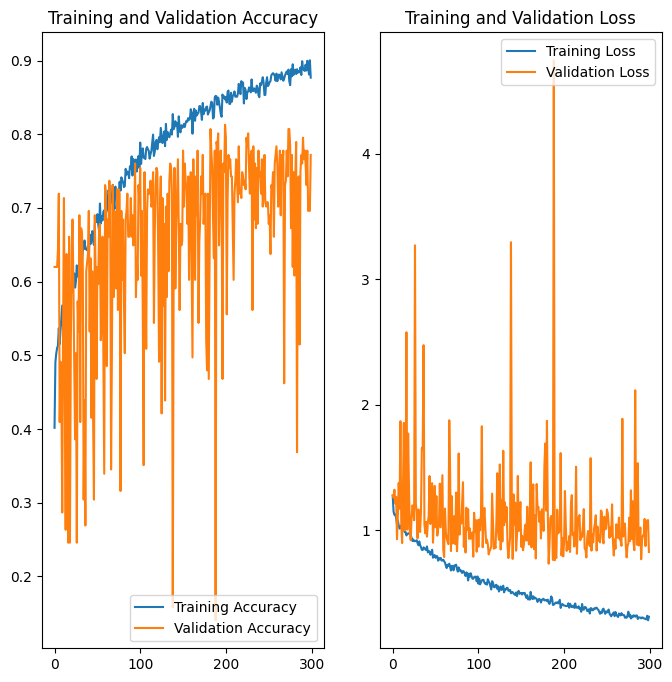

In [12]:
plot_training_history(history, epochs_range=range(300))

2024-06-26 03:18:04.159328: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:784] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Found an unshardable source dataset: name: "TensorDataset/_1"
op: "TensorDataset"
input: "Placeholder/_0"
attr {
  key: "Toutput_types"
  value {
    list {
      type: DT_INT32
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: 1
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\023TensorDataset:14133"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
      }
    }
  }
}
experimental_type {
  type_id: TFT_PRODUCT
  args {
    type_id: TFT_DATASET
    args {
      type_id: TFT_PRODUCT
      args {
        type_id: TFT_TENSOR
        args {
          type_id: TFT_INT32
        }
      }
    }
  }
}



11/11 [==============================] - 4s 111ms/step
              precision    recall  f1-score   support

           0       0.64      0.58      0.61       106
           1       0.21      0.17      0.19        24
           2       0.10      0.08      0.09        13
           3       0.17      0.29      0.21        28

    accuracy                           0.43       171
   macro avg       0.28      0.28      0.27       171
weighted avg       0.46      0.43      0.44       171



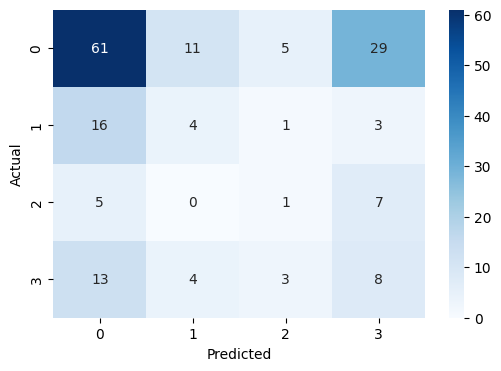

In [13]:
evaluate_and_visualize_model(model, val_generator)

### ResNet50 + CBAM

In [11]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, UpSampling2D, Concatenate, GlobalAveragePooling2D, Dense, Dropout, BatchNormalization, Activation, Input, LeakyReLU
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import tensorflow as tf

# logical_gpus = tf.config.experimental.list_logical_devices ('GPU')
# strategy = tf.distribute.MirroredStrategy(logical_gpus)

strategy = tf.distribute.MirroredStrategy()

with strategy.scope():
    # 데이터 증강 설정
    data_gen_args = dict(
        rescale=1./255,
        horizontal_flip=True,
        vertical_flip=True,
        brightness_range=[0.7, 1.3],
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        zoom_range=0.2
    )

    # 데이터 증강 생성기
    train_datagen = ImageDataGenerator(**data_gen_args)
    test_datagen = ImageDataGenerator(rescale=1./255)

    # 데이터 증강 적용 (train_data는 데이터프레임 형태라고 가정)
    train_generator = train_datagen.flow_from_dataframe(
        dataframe=train_data,
        x_col='image_path',
        y_col='label',
        target_size=(224, 224),
        batch_size=16,  # 배치 크기를 줄임
        class_mode='categorical'
    )

    val_generator = test_datagen.flow_from_dataframe(
        dataframe=test_data,
        x_col='image_path',
        y_col='label',
        target_size=(224, 224),
        batch_size=16,  # 배치 크기를 줄임
        class_mode='categorical'
    )

    # Channel Attention Module 정의
    def channel_attention(x):
        avg_pool = GlobalAveragePooling2D()(x)
        max_pool = GlobalAveragePooling2D()(x)
        dense_avg = Dense(x.shape[-1], activation='relu', kernel_initializer='he_normal', use_bias=True, bias_initializer='zeros')(avg_pool)
        dense_max = Dense(x.shape[-1], activation='relu', kernel_initializer='he_normal', use_bias=True, bias_initializer='zeros')(max_pool)
        combined = tf.keras.layers.add([dense_avg, dense_max])
        channel_attention = Activation('sigmoid')(combined)
        return tf.keras.layers.multiply([x, channel_attention])

    # Spatial Attention Module 정의
    def spatial_attention(x):
        avg_pool = tf.reduce_mean(x, axis=-1, keepdims=True)
        max_pool = tf.reduce_max(x, axis=-1, keepdims=True)
        combined = Concatenate(axis=-1)([avg_pool, max_pool])
        spatial_attention = Conv2D(1, (7, 7), padding='same', activation='sigmoid', kernel_initializer='he_normal', use_bias=False)(combined)
        return tf.keras.layers.multiply([x, spatial_attention])

    # CBAM Block 정의
    def cbam_block(x):
        x = channel_attention(x)
        x = spatial_attention(x)
        return x

    # ResNet50 모델 불러오기 (최종 분류 레이어 제외)
    base_model = ResNet50(include_top=False, input_tensor=Input(shape=(224, 224, 3)))
    x = base_model.output
    
    # CBAM Block 추가
    x = cbam_block(x)
    
    # Global Average Pooling 및 Dense 레이어 추가
    x = GlobalAveragePooling2D()(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.3)(x)
    output = Dense(4, activation='softmax')(x)

    # 최종 모델 정의
    model = Model(inputs=base_model.input, outputs=output)

    # 모델 컴파일
    model.compile(optimizer=Adam(learning_rate=0.0001, beta_1=0.9, beta_2=0.999), loss='categorical_crossentropy', metrics=['accuracy'])

    # 모델 학습
    history = model.fit(
        train_generator,
        steps_per_epoch=len(train_generator),
        epochs=50,
        validation_data=val_generator,
        validation_steps=len(val_generator)
    )


INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1', '/job:localhost/replica:0/task:0/device:GPU:2', '/job:localhost/replica:0/task:0/device:GPU:3')
Found 1656 validated image filenames belonging to 4 classes.
Found 171 validated image filenames belonging to 4 classes.
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 the

2024-06-26 12:52:03.880721: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-26 12:52:05.593424: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 14825 MB memory:  -> device: 0, name: Quadro RTX 5000, pci bus id: 0000:3b:00.0, compute capability: 7.5
2024-06-26 12:52:05.594542: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 14825 MB memory:  -> device: 1, name: Quadro RTX 5000, pci bus id: 0000:5e:00.0, compute capability: 7.5
2024-06-26 12:52:05.595503: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:local

Epoch 1/50
INFO:tensorflow:batch_all_reduce: 221 all-reduces with algorithm = nccl, num_packs = 1
INFO:tensorflow:batch_all_reduce: 221 all-reduces with algorithm = nccl, num_packs = 1


2024-06-26 12:53:23.299081: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8907
2024-06-26 12:53:24.264730: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8907
2024-06-26 12:53:25.277557: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8907
2024-06-26 12:53:25.649974: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-06-26 12:53:25.653531: W tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You may not need to update to CUDA 11.1; cherry-picking the ptxas binary is often sufficient.
2024-06-26 12:53:25.676475: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8907
2024-06-26 12:53:2

104/104 [==============================] - ETA: 0s - loss: 0.9358 - accuracy: 0.6141

2024-06-26 12:54:22.260553: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:784] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Found an unshardable source dataset: name: "TensorDataset/_1"
op: "TensorDataset"
input: "Placeholder/_0"
attr {
  key: "Toutput_types"
  value {
    list {
      type: DT_INT32
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: 1
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\020TensorDataset:40"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
      }
    }
  }
}
experimental_type {
  type_id: TFT_PRODUCT
  args {
    type_id: TFT_DATASET
    args {
      type_id: TFT_PRODUCT
      args {
        type_id: TFT_TENSOR
        args {
          type_id: TFT_INT32
        }
      }
    }
  }
}



104/104 [==============================] - 139s 327ms/step - loss: 0.9358 - accuracy: 0.6141 - val_loss: 1.5278 - val_accuracy: 0.0760
Epoch 2/50
104/104 [==============================] - 28s 265ms/step - loss: 0.5591 - accuracy: 0.7880 - val_loss: 1.6029 - val_accuracy: 0.0760
Epoch 3/50
104/104 [==============================] - 28s 265ms/step - loss: 0.4710 - accuracy: 0.8406 - val_loss: 1.2432 - val_accuracy: 0.6199
Epoch 4/50
104/104 [==============================] - 28s 267ms/step - loss: 0.3826 - accuracy: 0.8508 - val_loss: 1.2922 - val_accuracy: 0.4678
Epoch 5/50
104/104 [==============================] - 28s 265ms/step - loss: 0.3367 - accuracy: 0.8798 - val_loss: 1.2310 - val_accuracy: 0.6140
Epoch 6/50
104/104 [==============================] - 28s 266ms/step - loss: 0.3123 - accuracy: 0.8774 - val_loss: 1.3986 - val_accuracy: 0.5731
Epoch 7/50
104/104 [==============================] - 28s 265ms/step - loss: 0.2725 - accuracy: 0.8955 - val_loss: 1.9265 - val_accuracy: 0.

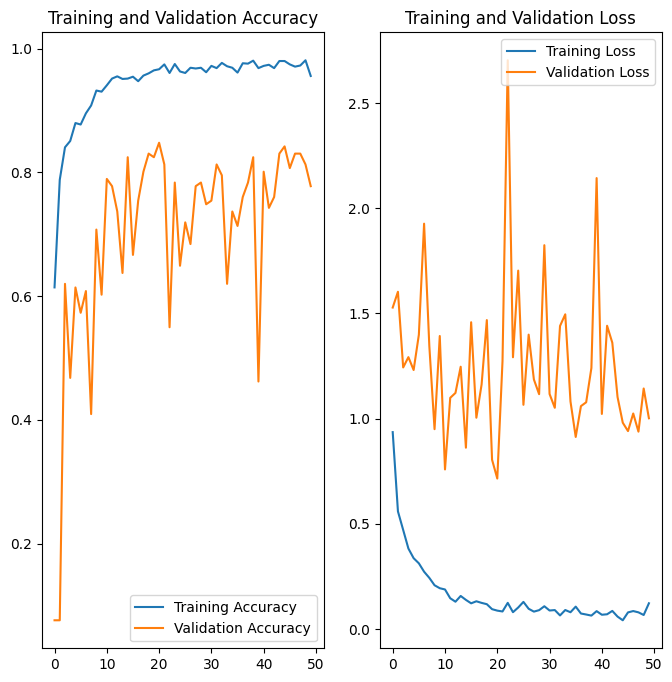

In [12]:
plot_training_history(history, epochs_range=range(50))

2024-06-26 13:17:18.779729: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:784] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Found an unshardable source dataset: name: "TensorDataset/_1"
op: "TensorDataset"
input: "Placeholder/_0"
attr {
  key: "Toutput_types"
  value {
    list {
      type: DT_INT32
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: 1
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\022TensorDataset:2383"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
      }
    }
  }
}
experimental_type {
  type_id: TFT_PRODUCT
  args {
    type_id: TFT_DATASET
    args {
      type_id: TFT_PRODUCT
      args {
        type_id: TFT_TENSOR
        args {
          type_id: TFT_INT32
        }
      }
    }
  }
}



11/11 [==============================] - 6s 115ms/step
              precision    recall  f1-score   support

           0       0.63      0.63      0.63       106
           1       0.19      0.29      0.23        24
           2       0.14      0.08      0.10        13
           3       0.19      0.14      0.16        28

    accuracy                           0.46       171
   macro avg       0.29      0.29      0.28       171
weighted avg       0.46      0.46      0.46       171



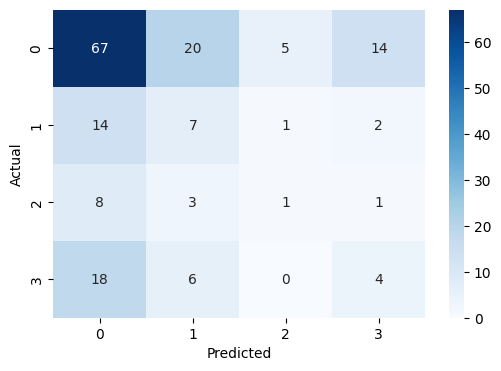

In [13]:
evaluate_and_visualize_model(model, val_generator)

### ResNet50 + CBAM(tanh)

In [13]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, UpSampling2D, Concatenate, GlobalAveragePooling2D, Dense, Dropout, BatchNormalization, Activation, Input, LeakyReLU, Add
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import tensorflow as tf

strategy = tf.distribute.MirroredStrategy()

with strategy.scope():
    # 데이터 증강 설정
    data_gen_args = dict(
        rescale=1./255,
        horizontal_flip=True,
        vertical_flip=True,
        brightness_range=[0.7, 1.3],
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        zoom_range=0.2
    )

    # 데이터 증강 생성기
    train_datagen = ImageDataGenerator(**data_gen_args)
    test_datagen = ImageDataGenerator(rescale=1./255)

    # 데이터 증강 적용 (train_data는 데이터프레임 형태라고 가정)
    train_generator = train_datagen.flow_from_dataframe(
        dataframe=train_data,
        x_col='image_path',
        y_col='label',
        target_size=(224, 224),
        batch_size=16,
        class_mode='categorical'
    )

    val_generator = test_datagen.flow_from_dataframe(
        dataframe=test_data,
        x_col='image_path',
        y_col='label',
        target_size=(224, 224),
        batch_size=16,
        class_mode='categorical'
    )

    # Channel Attention Module 정의 (tanh 사용)
    def channel_attention(x):
        avg_pool = tf.reduce_mean(x, axis=[1, 2], keepdims=True)
        max_pool = tf.reduce_max(x, axis=[1, 2], keepdims=True)
        dense_avg = Dense(x.shape[-1] // 8, activation='tanh', kernel_initializer='he_normal', use_bias=True, bias_initializer='zeros')(avg_pool)
        dense_avg = Dense(x.shape[-1], activation='sigmoid', kernel_initializer='he_normal', use_bias=True, bias_initializer='zeros')(dense_avg)
        dense_max = Dense(x.shape[-1] // 8, activation='tanh', kernel_initializer='he_normal', use_bias=True, bias_initializer='zeros')(max_pool)
        dense_max = Dense(x.shape[-1], activation='sigmoid', kernel_initializer='he_normal', use_bias=True, bias_initializer='zeros')(dense_max)
        combined = Add()([dense_avg, dense_max])
        return tf.keras.layers.multiply([x, combined])

    # Spatial Attention Module 정의
    def spatial_attention(x):
        avg_pool = tf.reduce_mean(x, axis=-1, keepdims=True)
        max_pool = tf.reduce_max(x, axis=-1, keepdims=True)
        combined = Concatenate(axis=-1)([avg_pool, max_pool])
        spatial_attention = Conv2D(1, (7, 7), padding='same', activation='sigmoid', kernel_initializer='he_normal', use_bias=False)(combined)
        return tf.keras.layers.multiply([x, spatial_attention])

    # CBAM Block 정의
    def cbam_block(x):
        x = channel_attention(x)
        x = spatial_attention(x)
        return x

    # ResNet50 모델 불러오기 (최종 분류 레이어 제외)
    base_model = ResNet50(include_top=False, input_tensor=Input(shape=(224, 224, 3)))
    x = base_model.output

    # CBAM Block 추가
    x = cbam_block(x)

    # Global Average Pooling 및 Dense 레이어 추가
    x = GlobalAveragePooling2D()(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.3)(x)
    output = Dense(4, activation='softmax')(x)

    # 최종 모델 정의
    model = Model(inputs=base_model.input, outputs=output)

    # 모델 컴파일
    model.compile(optimizer=Adam(learning_rate=0.0001, beta_1=0.9, beta_2=0.999), loss='categorical_crossentropy', metrics=['accuracy'])

    # 모델 학습
    history = model.fit(
        train_generator,
        steps_per_epoch=len(train_generator),
        epochs=50,
        validation_data=val_generator,
        validation_steps=len(val_generator)
    )


INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1', '/job:localhost/replica:0/task:0/device:GPU:2', '/job:localhost/replica:0/task:0/device:GPU:3')


Found 1656 validated image filenames belonging to 4 classes.
Found 171 validated image filenames belonging to 4 classes.


2024-06-25 23:27:55.244475: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:784] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Found an unshardable source dataset: name: "TensorDataset/_1"
op: "TensorDataset"
input: "Placeholder/_0"
attr {
  key: "Toutput_types"
  value {
    list {
      type: DT_INT32
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: 1
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\022TensorDataset:1443"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
      }
    }
  }
}
experimental_type {
  type_id: TFT_PRODUCT
  args {
    type_id: TFT_DATASET
    args {
      type_id: TFT_PRODUCT
      args {
        type_id: TFT_TENSOR
        args {
          type_id: TFT_INT32
        }
      }
    }
  }
}



Epoch 1/50
INFO:tensorflow:batch_all_reduce: 225 all-reduces with algorithm = nccl, num_packs = 1
INFO:tensorflow:batch_all_reduce: 225 all-reduces with algorithm = nccl, num_packs = 1
104/104 [==============================] - ETA: 0s - loss: 1.2574 - accuracy: 0.4094

2024-06-25 23:30:00.363911: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:784] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Found an unshardable source dataset: name: "TensorDataset/_1"
op: "TensorDataset"
input: "Placeholder/_0"
attr {
  key: "Toutput_types"
  value {
    list {
      type: DT_INT32
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: 1
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\022TensorDataset:1483"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
      }
    }
  }
}
experimental_type {
  type_id: TFT_PRODUCT
  args {
    type_id: TFT_DATASET
    args {
      type_id: TFT_PRODUCT
      args {
        type_id: TFT_TENSOR
        args {
          type_id: TFT_INT32
        }
      }
    }
  }
}



104/104 [==============================] - 131s 310ms/step - loss: 1.2574 - accuracy: 0.4094 - val_loss: 1.4496 - val_accuracy: 0.1637
Epoch 2/50
104/104 [==============================] - 28s 267ms/step - loss: 0.8434 - accuracy: 0.6715 - val_loss: 1.2900 - val_accuracy: 0.6199
Epoch 3/50
104/104 [==============================] - 28s 266ms/step - loss: 0.5849 - accuracy: 0.7802 - val_loss: 1.2738 - val_accuracy: 0.6199
Epoch 4/50
104/104 [==============================] - 28s 267ms/step - loss: 0.4430 - accuracy: 0.8303 - val_loss: 1.9022 - val_accuracy: 0.1404
Epoch 5/50
104/104 [==============================] - 28s 265ms/step - loss: 0.3644 - accuracy: 0.8690 - val_loss: 1.2910 - val_accuracy: 0.6374
Epoch 6/50
104/104 [==============================] - 28s 265ms/step - loss: 0.3362 - accuracy: 0.8810 - val_loss: 1.3017 - val_accuracy: 0.6374
Epoch 7/50
104/104 [==============================] - 28s 263ms/step - loss: 0.2924 - accuracy: 0.8865 - val_loss: 1.5151 - val_accuracy: 0.

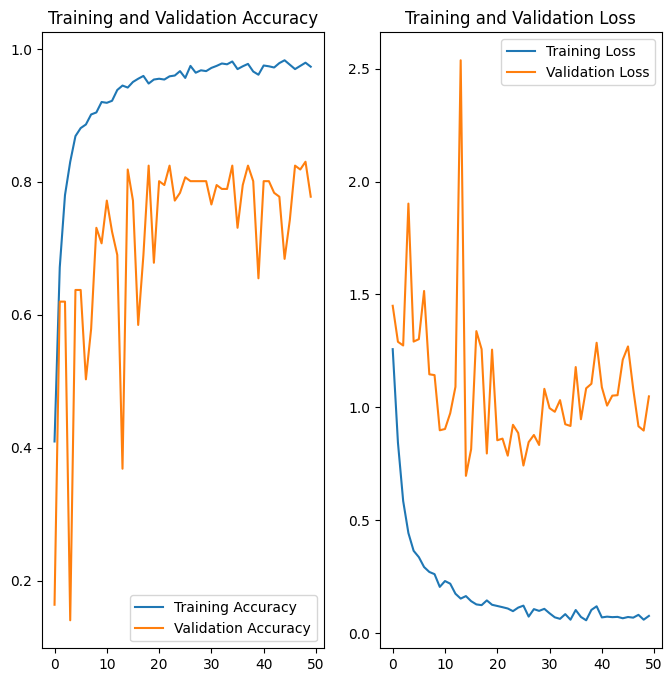

In [18]:
plot_training_history(history, epochs_range=range(50))

2024-06-26 00:54:22.185037: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:784] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Found an unshardable source dataset: name: "TensorDataset/_1"
op: "TensorDataset"
input: "Placeholder/_0"
attr {
  key: "Toutput_types"
  value {
    list {
      type: DT_INT32
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: 1
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\022TensorDataset:3991"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
      }
    }
  }
}
experimental_type {
  type_id: TFT_PRODUCT
  args {
    type_id: TFT_DATASET
    args {
      type_id: TFT_PRODUCT
      args {
        type_id: TFT_TENSOR
        args {
          type_id: TFT_INT32
        }
      }
    }
  }
}



11/11 [==============================] - 2s 118ms/step
              precision    recall  f1-score   support

           0       0.62      0.61      0.62       106
           1       0.11      0.12      0.12        24
           2       0.00      0.00      0.00        13
           3       0.20      0.18      0.19        28

    accuracy                           0.43       171
   macro avg       0.23      0.23      0.23       171
weighted avg       0.43      0.43      0.43       171



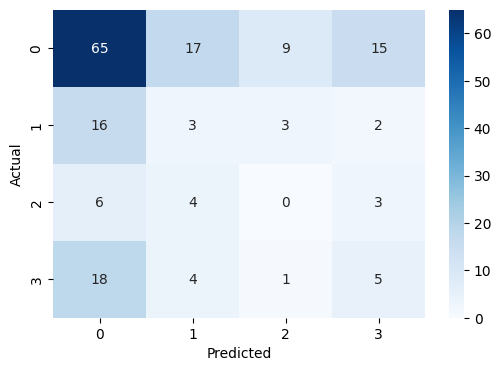

In [28]:
evaluate_and_visualize_model(model, val_generator)

In [11]:
# Stage 1 summary
stage1_output = stage1(input_tensor)
stage1_model = Model(inputs=input_tensor, outputs=stage1_output)
print("Stage 1 Summary:")
stage1_model.summary()

Stage 1 Summary:
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv2d_4 (Conv2D)           (None, 224, 224, 32)      896       
                                                                 
 batch_normalization_3 (Batc  (None, 224, 224, 32)     128       
 hNormalization)                                                 
                                                                 
 activation_4 (Activation)   (None, 224, 224, 32)      0         
                                                                 
 conv2d_5 (Conv2D)           (None, 224, 224, 32)      9248      
                                                                 
 batch_normalization_4 (Batc  (None, 224, 224, 32)     128       
 hNormalization)                            

In [21]:
# Stage 2 summary
stage2_output = stage2(stage1_output)
stage2_model = Model(inputs=input_tensor, outputs=stage2_output)
print("\nStage 2 Summary:")
stage2_model.summary()


Stage 2 Summary:
Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_12 (Conv2D)             (None, 224, 224, 32  896         ['input_3[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_9 (BatchNo  (None, 224, 224, 32  128        ['conv2d_12[0][0]']              
 rmalization)                   )                                         

In [22]:
# Stage 3 summary
stage3_output = stage3(stage2_output)
stage3_model = Model(inputs=input_tensor, outputs=stage3_output)
print("\nStage 3 Summary:")
stage3_model.summary()


Stage 3 Summary:
Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_12 (Conv2D)             (None, 224, 224, 32  896         ['input_3[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_9 (BatchNo  (None, 224, 224, 32  128        ['conv2d_12[0][0]']              
 rmalization)                   )                                         

                                                                                                  
 up_sampling2d_3 (UpSampling2D)  (None, 224, 224, 32  0          ['max_pooling2d_3[0][0]']        
                                )                                                                 
                                                                                                  
 conv2d_22 (Conv2D)             (None, 224, 224, 64  18496       ['up_sampling2d_3[0][0]']        
                                )                                                                 
                                                                                                  
 batch_normalization_17 (BatchN  (None, 224, 224, 64  256        ['conv2d_22[0][0]']              
 ormalization)                  )                                                                 
                                                                                                  
 activatio